In [1]:
import Main
import Parser
from Analyser2 import *

In [2]:
modelName = 'dereffye'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
t1 = Main.generate_and_analyse(modelName, {})
t1

{'parentAngle_mean': 32.350495879480974,
 'parentAngle_variance': 15.505356874806948,
 'length_mean': 1.4055027827336024,
 'length_variance': 0.9057108250017012,
 'verticalOrientation_mean': 49.46363933097293,
 'verticalOrientation_variance': 27.67644720924997,
 'horizontalOrientation_mean': 170.647590984774,
 'horizontalOrientation_variance': 106.34332469066447,
 'q1_xyz': (8.75053360455915, 27.0789135736933, 35.52077939622322),
 'q2_xyz': (42.56760470785327, 25.327431105924507, 66.75845647766727),
 'q3_xyz': (44.40385383710904, 27.746847622014933, 41.013425462414986),
 'xyz': (45.32098598860367, 79.74730372746824, 67.87524480456163),
 'trunk_length': 10.0,
 'totalBiomass': 397.23712082645477}

In [18]:
metrics = {  'section_1_slash':(10, 100),
             'section_1_slashr':(10, 100),
            'section_1_plus':(0,180),
            'section_1_plusr':(0,180),
             'section_1_decay':(0, 1),
           'section_1_h':(1,20),
             'section_1_w':(0.1, 2),
          }

In [7]:
prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
                     section_1_slashr    =RV("uniform", 10, 100),
                     section_1_plus      =RV("uniform", 0, 180),
                     section_1_plusr      =RV("uniform", 0, 180),
                     section_1_decay     =RV("uniform", 0, 1),
                     section_1_h         =RV("uniform", 1, 20),
                     section_1_w         =RV("uniform", 0.1, 2),
                    )

In [8]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [9]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [10]:
target = gen_av_target(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
target

{'parentAngle_mean': 34.33422676631847,
 'parentAngle_variance': 16.673559844586823,
 'length_mean': 1.4757779218702827,
 'length_variance': 0.9509963662517865,
 'verticalOrientation_mean': 52.35384178364635,
 'verticalOrientation_variance': 29.215995092418986,
 'horizontalOrientation_mean': 182.32756398060954,
 'horizontalOrientation_variance': 107.49853434054278,
 'q1_xyz': (16.259582259371438, 28.38796645133682, 22.61638703252617),
 'q2_xyz': (48.63921038278238, 26.56579250902997, 54.24267475412245),
 'q3_xyz': (48.93084108968644, 29.181432782513536, 42.19126316789423),
 'xyz': (54.089959965907575, 83.73466891384166, 57.19915753895124),
 'trunk_length': 10.5,
 'totalBiomass': 417.0989768677776}

In [12]:
mp = 13
me = 0.5

In [13]:
abc = ABCSMC(model, prior, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=2, start_time=2019-05-20 14:59:28.218385, end_time=None)>
INFO:Epsilon:initial epsilon is 15.615702739515347
INFO:ABC:t:0 eps:15.615702739515347
INFO:ABC:t:1 eps:12.164529173876401
INFO:ABC:t:2 eps:10.203730332360953
INFO:ABC:t:3 eps:8.53953129176776
INFO:ABC:t:4 eps:7.343101034892944
INFO:ABC:t:5 eps:6.547706528936959
INFO:ABC:t:6 eps:5.954116395984418
INFO:ABC:t:7 eps:5.573240378127381
INFO:ABC:t:8 eps:4.796589623090945
INFO:ABC:t:9 eps:4.3483744414906305
INFO:ABC:t:10 eps:4.023337839157822
INFO:ABC:t:11 eps:3.5509614164710634
INFO:ABC:t:12 eps:3.280242526414656
INFO:History:Done <ABCSMC(id=2, start_time=2019-05-20 14:59:28.218385, end_time=2019-05-20 15:10:13.785250)>


In [14]:
from pyabc.visualization import plot_kde_1d

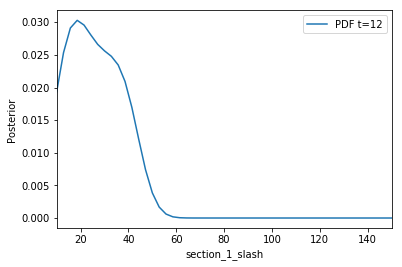

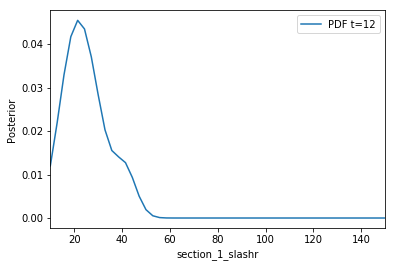

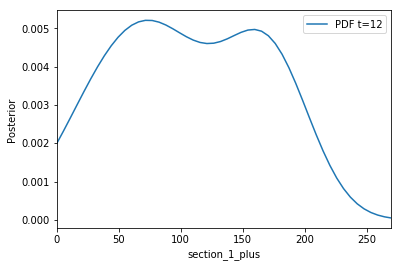

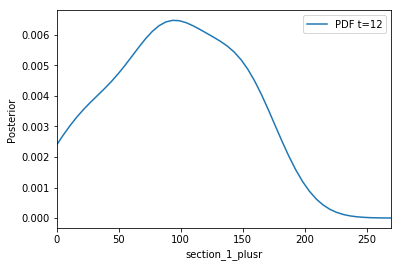

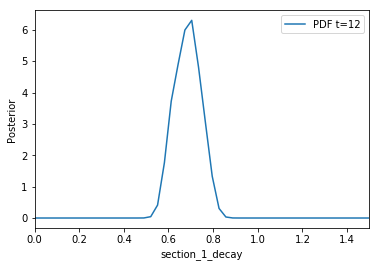

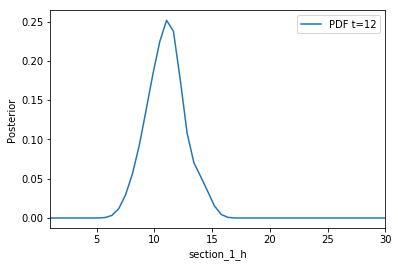

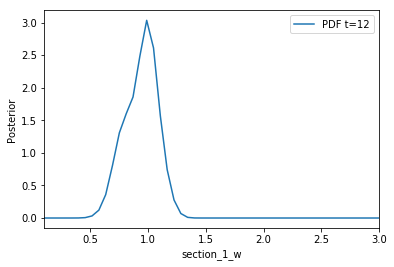

In [19]:
# Visualise results
for k,v in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('../../../../Report/images/dereffye_angles/'+k+'_kde')